# Bayes by Backprop: Mushroom Contextual Bandit

__Background - Multi-armed and Contextual Bandit problems:__ <br>
_“Bandit”_ in _“multi-armed bandits”_ comes from _“one-armed bandit”_ machines used in a casino. Imagine that you are in a casino with many one-armed bandit machines. Each machine has a different probability of a win. Your goal is to maximize total payout. You can pull a limited number of arms, and you don’t know which bandit to use to get the best payout. The problem involves exploration/exploitation tradeoff: you should balance between trying different bandits to learn more about an expected payout of every machine, but you also want to exploit the best bandit you know about more. While multi-armed bandits select the strategy which maximises the expected reward without taking into consideration the state of the environment, _contextual bandits_ output an action based on the context.

__Mushroom Case Stuty:__ <br>
We are provided with a list of 8124 mushrooms, each having 22 features (characteristcs of the mushroom) and 1 label (poisonous or edible). Our agent can carry out 2 actions: eat a mushroom or not eat a mushroom. The problem context is the vector of features which is associated with the mushroom which the agent is about to eat/non eat.
If our agent eats an edible mushroom, it receives a reward of 5. If the agent eats a poisonous mushroom, it receives a reward of -35 with 0.5 probability and a reward of 5 with 0.5 probaility. If the agent doesn't eat, it receives a reward o 0.

We are also provided an _oracle_. The oracle always selects the right action, receiving a reward of 5 when it eats an edible mushroom, and a reward of 0 when it doesn't eat.

__Objective:__ <br>
Create a BNN which minimises the _cumulative regret_ of the agent. Regreat measures the difference between the oracle and our agent's reward.

__BNN Architecture:__
- 2 hidden layers
- Each layer has 100 rectified units
- Vector input: vector consisting of the mushroom features (context) and a one of _K_ encoding of the action
- Output: single scalar representing the expected reward of the given action in the given context

__Additional Important Information:__
- To calculate the expected reward for an action, Google samples twice the weights and averages the outputs
- To train the network, Google keeps a buffer of 4096 mushrooms.
- For training, Google randomly draws minibatches of size 64 for 64 training steps.
- After every training stage, the agent interacts with a new mushroom

## TASKS:
- Data preparation: DONE
- Reward function: DONE
- Initialise buffer function: DONE
- Update buffer function: DONE
- Create class for Gaussian distribution: DONE
- Create class for generating prior distribution: DONE
- Create class for generating BNN layer: DONE
- Create BNN: Need to change
- Create function for creating network estimates: TO BE DONE
- Create function for updating network parameters: TO BE DONE


### Algorithm for network estimtes:
##### Inputs: network and mushroom - Returns rewards for both actions
def network-estimates(network, mushroom): <br>
    sample w1,w2<br>
    r1 = 0.5 * (f(mushroom,eat, w1) + f(mushroom,don't eat, w1))<br>
    r2 = 0.5 * (f(mushroom,eat, w2) + f(mushroom,don't eat, w2))<br>
    return r1,r2<br>
    


In [1]:
# Import Libraries

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from sklearn import metrics
import random
import sys
sys.path.append('../')
from BayesBackpropagation import *

Cuda available?:  True


## __Data Preparation:__ ## 
Input is the data file. Output is an array of one-hot encoded labels (y, shape: 8124) and an array of context features (x, shape: 8124 elements, each with 117 features). 117 features derive from doing a one-hot encoding on the feature classes.

In [2]:
# Import data from file
df = pd.read_csv(os.getcwd() + '/agaricus-lepiota.data', sep=',', header=None,
             error_bad_lines=False, warn_bad_lines=True, low_memory=False)

# Set pandas to output all of the columns in output
df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
         'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
         'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
         'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']

# Split context from label
X = pd.DataFrame(df, columns=df.columns[1:len(df.columns)], index=df.index)
# Put the class values (0th column) into Y
Y = df['class']

# Transform labels into one-hot encoded array
le = preprocessing.LabelEncoder()
le.fit(Y)
y = le.transform(Y)

# Temporary variable to avoid error 
x_tmp = pd.DataFrame(X,columns=[X.columns[0]])

# Encode each feature column and add it to x_train 
for colname in X.columns:
    le.fit(X[colname])
    #print(colname, le.classes_)
    x_tmp[colname] = le.transform(X[colname])

# Produce mushroom array: 8124 mushrooms, each with 117 one-hot encoded features
oh = preprocessing.OneHotEncoder(categorical_features='all')
oh.fit(x_tmp)
x = oh.transform(x_tmp).toarray()

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:375: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. The passed value of 'all' is the default and can simply be removed.
  DeprecationWarning)


## __Reward function:__ ##
Implemented as described above

In [3]:
x.shape

(8124, 117)

In [4]:
# REWARD FUNCTION

def get_reward(eaten, edible):
    # REWARDS FOR AGENT
    #  Eat poisonous mushroom
    if not eaten:
        return 0
    if eaten and edible:
        return 5
    elif eaten and not edible:
        return (5 if np.random.rand() > 0.5 else -35)

def oracle_reward(edible):
    return 5*edible    

## Create Mushroom Buffer
Generate buffer to keep 4096 elements used to train the Bayesian Neural Network

In [5]:
def init_buffer():
    bufferX, bufferY = [], []
    for i in np.random.choice(range(len(x)), 4096):
        eat = np.random.rand()>0.5
        bufferX.append(np.concatenate((x[i], [1, 0] if eat else [0, 1])))
        bufferY.append(get_reward(eat, y[i]))
    return bufferX, bufferY

## Neural Network


In [6]:
# Define some hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print("Cuda available?: ",torch.cuda.is_available())

PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

Cuda available?:  True


### Create class for Gaussian distribution

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import sys

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))


class MushroomNet():
    def __init__(self, label='MushNet', n_weight_sampling = 1):
        self.n_weight_sampling = n_weight_sampling
        self.label = label
        self.epsilon = 0
        self.net = None
        self.bufferX, self.bufferY = init_buffer()
        self.loss, self.optimizer = None, None
        self.cum_regrets = [0]
    
    def expected_rewards(self, context):
        k = self.n_weight_sampling
        c_eat = Var(np.concatenate((context, [1, 0])))
        c_reject = Var(np.concatenate((context, [0, 1])))
        with torch.no_grad():
            r_eat = np.mean([self.net.forward(c_eat).numpy().reshape(1)[0] for _ in range(k)])
            r_reject = np.mean([self.net.forward(c_reject).numpy().reshape(1)[0] for _ in range(k)])
        return r_reject, r_eat

    def try_(self, mushroom):
        context, edible = x[mushroom], y[mushroom]
        r_reject, r_eat = self.expected_rewards(context)
        eaten = r_eat > r_reject
        if np.random.rand()<self.epsilon:
            eaten = (np.random.rand()<.5)
        reward = get_reward(eaten, edible)
        action = [1, 0] if eaten else [0, 1]
        self.bufferX.append(np.concatenate((context, action)))
        self.bufferY.append(reward)
        rg = oracle_reward(edible) - reward
        self.cum_regrets.append(self.cum_regrets[-1]+rg)
    
    def update(self, mushroom):
        self.try_(mushroom)
        bX = Var(np.array(self.bufferX[-4096:]))
        bY = Var(np.array(self.bufferY[-4096:]))
        for idx in np.split(np.random.permutation(range(4096)), 64):
            #self.net.train()
            self.net.zero_grad()
            self.loss(bX[idx], bY[idx]).backward()
            self.optimizer.step()

In [11]:
class BBB_MNet(MushroomNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.net = BayesianNetwork(inputSize = x.shape[1]+2,
                          CLASSES = 1, 
                          layers=np.array([100,100]), 
                          activations = np.array(['relu','relu','none']), 
                          SAMPLES = 5, 
                          BATCH_SIZE = 64,
                          NUM_BATCHES = 64,
                                  hasScalarMixturePrior = True,
                                  pi = PI, 
                                  sigma1 = SIGMA_1,
                                  sigma2 = SIGMA_2).to(DEVICE)
        self.optimizer = optim.Adam(self.net.parameters())
        self.loss = lambda data, target:self.net.sample_elbo(data, target)[0]
        
        

class EpsGreedyMlp(MushroomNet):
    def __init__(self, epsilon=0, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.net = nn.Sequential(
        nn.Linear(x.shape[1]+2, 100), nn.ReLU(),
        nn.Linear(100, 100), nn.ReLU(),
        nn.Linear(100, 1))
        self.bufferX, self.bufferY = init_buffer()
        self.optimizer = optim.Adam(self.net.parameters())
        self.mse = nn.MSELoss()
        self.loss = lambda data, target: self.mse(self.net.forward(data), target)

In [12]:
mushroom_nets = {'bbb':BBB_MNet(label = 'BBB s2', 
                               n_weight_sampling = 2),
                 'bbb5':BBB_MNet(label = 'BBB s5', 
                               n_weight_sampling = 5),
                 'e0':EpsGreedyMlp(epsilon=0, label = 'Greedy'),
                 'e1':EpsGreedyMlp(epsilon=0.01, label = '1% Greedy'),
                 'e5':EpsGreedyMlp(epsilon=0.05, label = '5% Greedy')}

In [14]:
import plotly.graph_objs as go
class Fig(go.FigureWidget):
    def __init__(self):
        super().__init__([go.Scatter(name = net.label, x=[], y=[]) 
                          for i, net in mushroom_nets.items()])
        self.layout.title = 'Cumulative Regrets'
    
    def update(self, dic):
        for j, (lb, y) in enumerate(dic.items()):
            self.data[j].x = list(range(len(y)))
            self.data[j].y = y
    
    def save(self, file_name = 'mushroom_regrets.csv'):
        dic = {fd.name: fd.y for fd in self.data}
        pd.DataFrame.from_dict(dic).to_csv(file_name)
        
        
fig = Fig()
fig  

Fig({
    'data': [{'name': 'BBB s2', 'type': 'scatter', 'uid': '7084aa98-136a-42db-b963-8506248bc5ad', 'x': […

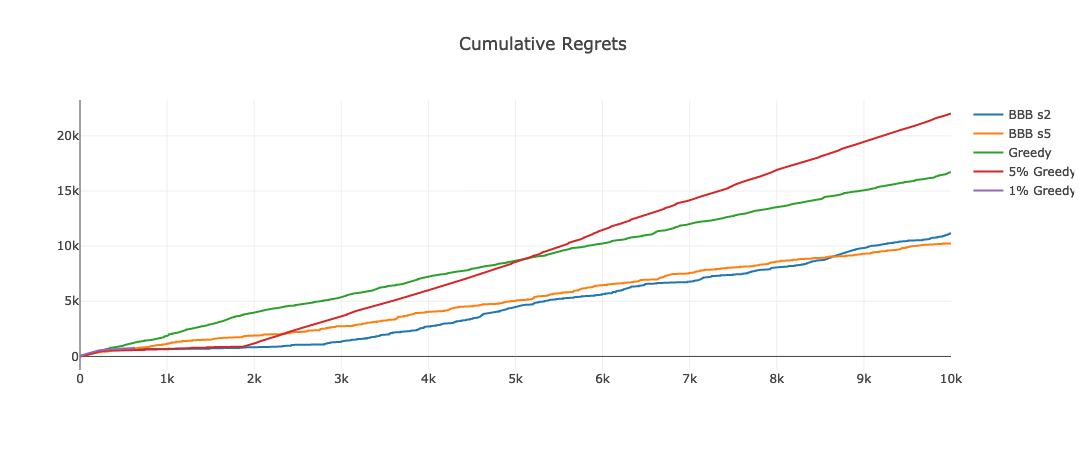

In [23]:
import plotly.offline as py
py.iplot(fig)

In [24]:
NB_STEPS = 250

offset = len(fig.data[0].x)
for _ in range(offset, offset+NB_STEPS):
    mushroom = np.random.randint(len(x))
    for j, (key, net) in enumerate(mushroom_nets.items()):
        net.update(mushroom)
    fig.update({net.label: net.cum_regrets for lb, net in mushroom_nets.items()})

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'

In [153]:
fig.save()

In [20]:
fig.update(pd.read_csv('mushroom_regrets_10000steps.csv', index_col= 0))

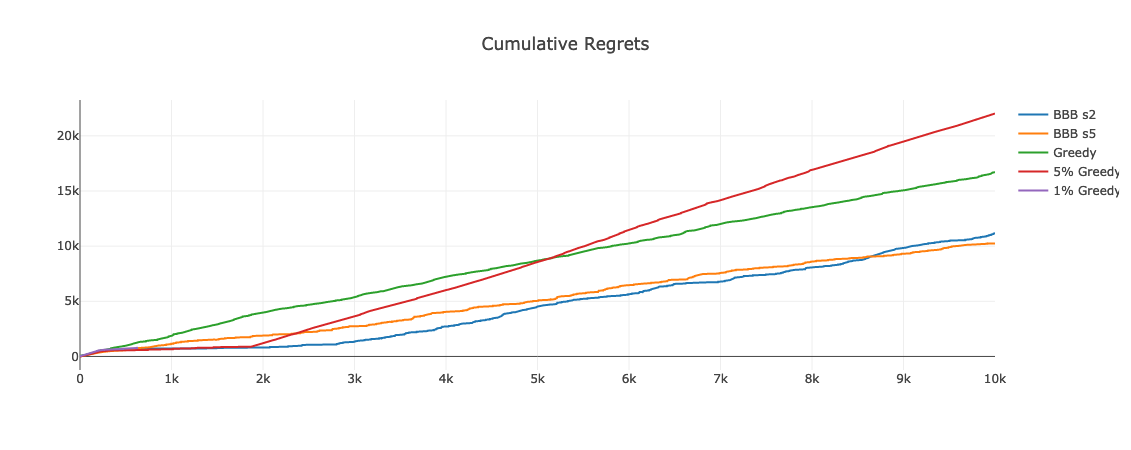

In [17]:
fig.

Fig({
    'data': [{'name': 'BBB s2', 'type': 'scatter', 'uid': '7084aa98-136a-42db-b963-8506248bc5ad', 'x': […

In [22]:
import plotly.io as pio
pio.write_json(fig, 'first_run.plotly')